#Trabalho 1 - Inteligência Artificial 


> Aluna : Juliana Camilo Repossi

> Prof. : Flávio Miguel Varejão

##Import de bibliotecas

In [1]:
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy import stats
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y




##Carregamento e manipulação da base de dados

In [2]:
#Leitura dos dados para o pandas
data_base = pd.read_csv('https://raw.githubusercontent.com/VitorBonella/PL-Dataset/main/dataset.csv',sep=";") 

#Transformando a coluna id no indice da tabela
data_base.set_index('id',inplace=True)

#Juntar as colunas 'tipo_lampada' e 'potencia' para compor nossa classificação final
data_base['classe'] = data_base['tipo_lampada'].str.replace(" ", "") + data_base['potencia'].astype(str) 

# Lista de características que serão usadas
FOURIER = ['df01', 'df02', 'df03', 'df04','df05', 'df06', 'df07', 'df08', 'df09', 'df10']
HU = ['i1', 'i2', 'i3', 'i4','i5', 'i6', 'i7']
HARALICK = ['probmax', 'energia', 'entropia', 'contraste','homogeneidade', 'correlacao']

# final de matrícula 1 - Todas as características
ALL = FOURIER + HU + HARALICK

#separar em dados e classificação
X_data = data_base[ALL]
y_data = data_base['classe'] 

# Trocar a "," por  "." para o python identificar cada célula como float
X_data = X_data.apply(lambda x: x.str.replace(',', '.').astype(float), axis=1)

#Primeira etapa

In [3]:
#constantes
semente = 36851234

## Tabela e função para os resultados - Tabela 1 pedida

In [4]:
#dataFrame para os resultados
results = pd.DataFrame(columns = ['Média', 'Desvio Padrão' ,'Limite Inferior','Limite Superior'])

#lista auxiliar com nome dos metodos
metodos_results = []

def inserirTabelaResults(tabela, nomeMetodo, scoresMetodo):

  mean = scoresMetodo.mean()
  std = scoresMetodo.std()
  inf,sup = stats.norm.interval(0.95, loc=mean, 
                               scale=std/np.sqrt(len(scoresMetodo)))
  
  metodos_results.append(nomeMetodo)
  tabela = pd.concat([tabela, pd.DataFrame.from_records([{'Média':mean, 'Desvio Padrão':std ,'Limite Inferior':inf,'Limite Superior':sup}])], ignore_index = True)
  tabela.index = metodos_results
  return tabela

## Tabela para a criação do Boxplot pedido

In [5]:
#dataFrame para os scores
scores = pd.DataFrame()

#lista auxiliar com nome dos metodos
metodos_scores = []

def inserirTabelaScores(tabela, nomeMetodo, scoresMetodo):

  scoresMetodo = pd.DataFrame(scoresMetodo)
  scoresMetodo = scoresMetodo.transpose()

  metodos_scores.append(nomeMetodo)
  tabela = pd.concat([tabela, scoresMetodo], ignore_index = True)
  tabela.index = metodos_scores
  return tabela


### Primeiro Classificador : ZeroR

In [6]:
scalar = StandardScaler()

zeroR = DummyClassifier()

pipeline = Pipeline([('transformer',scalar),('estimator',zeroR)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=semente)

scoresZR = cross_val_score(pipeline,X_data,y_data,
                         scoring='accuracy', cv = rkf)


results = inserirTabelaResults(results, 'ZR', scoresZR)

scores = inserirTabelaScores(scores, 'ZR',scoresZR)

##Segunda Parte - com hiperparâmetros



###Segundo Classificador : Bagging



In [7]:
scalar = StandardScaler()

bagging = BaggingClassifier(random_state=11)

pipeline = Pipeline([('transformer',scalar),('bagging',bagging)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=semente)

grade = {'bagging__n_estimators': [3,9,15,21]}

gs = GridSearchCV(estimator = pipeline, param_grid = grade,
                  scoring = 'accuracy', cv = 4)

scoresBA = cross_val_score(gs,X_data,y_data,
                         scoring='accuracy', cv = rkf)

results = inserirTabelaResults(results, 'BA', scoresBA)

scores = inserirTabelaScores(scores,'BA',scoresBA)



###Terceiro Classificador : AdaBoost



In [8]:
scalar = StandardScaler()

adaBoost = AdaBoostClassifier(random_state=11)

pipeline = Pipeline([('transformer',scalar),('boosting',adaBoost)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=semente)

grade = {'boosting__n_estimators': [3,9,15,21]}

gs = GridSearchCV(estimator = pipeline, param_grid = grade,
                  scoring = 'accuracy', cv = 4)

scoresAB = cross_val_score(gs,X_data,y_data,
                         scoring='accuracy', cv = rkf)

results = inserirTabelaResults(results, 'AB', scoresAB)

scores = inserirTabelaScores(scores,'AB',scoresAB)


###Quarto classificador : RandomForest



In [9]:
scalar = StandardScaler()

randFor = RandomForestClassifier(random_state=11)

pipeline = Pipeline([('transformer',scalar),('estimator',randFor)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=semente)

grade = {'estimator__n_estimators': [3,9,15,21]}

gs = GridSearchCV(estimator = pipeline, param_grid = grade,
                  scoring = 'accuracy', cv = 4)

scoresRF = cross_val_score(gs,X_data,y_data,
                         scoring='accuracy', cv = rkf)

results = inserirTabelaResults(results, 'RF', scoresRF)

scores = inserirTabelaScores(scores,'RF',scoresRF)

###Quinto classificador : Heterogeneus Pooling



In [10]:
from sklearn.metrics import max_error
#classificador Heterogênio
  # Árvore de Decisão (DT)
  # Naive Bayes Gaussiano (NB)
  # KNN

class HeterogeneusPoolingClassifier(BaseEstimator):
    def __init__(self,n_samples=1,random_state=None):
        super().__init__()
        self.random_state = random_state
        self.n_samples = n_samples
        self.dt = []
        self.nb = []
        self.knn = []
        self.distr = []
        
    def fit(self,x_train,y_train):
        
      x_train,y_train = check_X_y(x_train,y_train)

      freq_distr = []

      for class_value in np.unique(y_train):
        ex = len([1 for i in y_train if i == class_value])
        freq_distr.append((ex,class_value))

      for ex,class_value in sorted(freq_distr,reverse=True):
        self.distr.append(class_value)

      semente_resample = 0

      for i in range(self.n_samples):
        self.dt.append(DecisionTreeClassifier(random_state = self.random_state))
        self.nb.append(GaussianNB())
        self.knn.append(KNeighborsClassifier())

        if i == 0:

          self.dt[i].fit(x_train,y_train)
          self.nb[i].fit(x_train,y_train)
          self.knn[i].fit(x_train,y_train)

        else:

          x,y = resample(x_train,y_train, replace=True,random_state=semente_resample)

          semente_resample +=1

          self.dt[i].fit(x,y)
          self.nb[i].fit(x,y)
          self.knn[i].fit(x,y)         

          
    def predict(self,x_test):

      #linha é o classificador
      #coluna é o id da predição
      predicts = []
      final_pred = []

      for i in range(self.n_samples):

        predicts.append(self.dt[i].predict(x_test))
        predicts.append(self.nb[i].predict(x_test))
        predicts.append(self.knn[i].predict(x_test)) 

      for i in range(len(x_test)):
        list_predicts = []
        for j in range(self.n_samples):
          list_predicts.append(predicts[3*j][i])
          list_predicts.append(predicts[3*j+1][i])
          list_predicts.append(predicts[3*j+2][i])

        voting = []
        qtd_max_votos = 0

        #conta os votos
        for class_value in np.unique(list_predicts):   
          votos = len([1 for i in list_predicts if i == class_value])
          if votos > qtd_max_votos:
            qtd_max_votos = votos
          voting.append((class_value,votos))

        max_votos = []

        #classes com votação maxima
        for class_value,votos in voting:   
          if votos == qtd_max_votos:
            max_votos.append(class_value)
        
        #desempate
        if len(max_votos) > 1 :
          #pegar a primeira classe de maior freq que tenha votação max
          for class_value in self.distr:
            if class_value in max_votos:
              final_pred.append(class_value)
              break
        elif len(max_votos) == 1 :
          final_pred.append(max_votos[0])

      
      return np.array(final_pred)


scalar = StandardScaler()

HP = HeterogeneusPoolingClassifier(random_state=11)

pipeline = Pipeline([('transformer',scalar),('estimator',HP)])

rkf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=semente)

grade = {'estimator__n_samples':[1,3,5,7]}

gs = GridSearchCV(estimator = pipeline, param_grid = grade,scoring = 'accuracy', cv = 4)

scoresHP = cross_val_score(gs, X_data, y_data, scoring='accuracy', cv = rkf)

results = inserirTabelaResults(results, 'HP', scoresHP)

scores = inserirTabelaScores(scores,'HP',scoresHP)

##Tabela de resultados dos classificadores

In [11]:
results

,Média,Desvio Padrão,Limite Inferior,Limite Superior
ZR,0.165057,0.010883,0.161163,0.168952
BA,0.635632,0.074520,0.608966,0.662298
AB,0.339042,0.029170,0.328604,0.349480
RF,0.623142,0.074574,0.596456,0.649827
HP,0.581418,0.090653,0.548979,0.613857


##BoxPlot do desempenho dos classificadores

<Axes: >

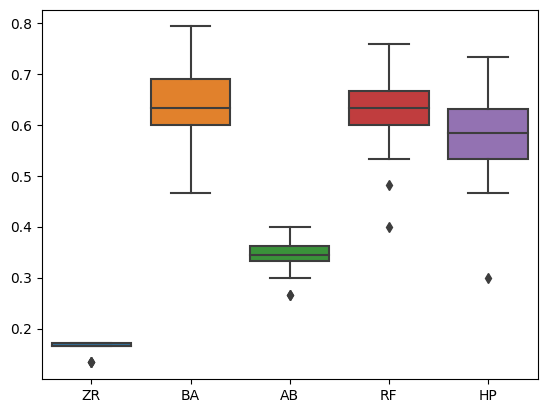

In [12]:
sns.boxplot(data=scores.transpose())


## Tabela para a comparação de resultados
  - Triangular superior - teste t pareado
  - Triangular inferior - teste de wilcoxon

In [13]:
testes = pd.DataFrame()

for i in range(len(metodos_scores)):
  newline = []
  for j in range(len(metodos_scores)):

    if i==j:
      newline.append(metodos_scores[i])
    elif i<j:
      t, p = stats.ttest_rel(scores.loc[metodos_scores[i]], 
                                     scores.loc[metodos_scores[j]])
      newline.append(p)

    else:
      t, p = stats.wilcoxon(scores.loc[metodos_scores[i]], 
                                     scores.loc[metodos_scores[j]],method = 'approx')
      newline.append(p)

  #adicionar linha ao dataframe
  testes = pd.concat([testes, pd.DataFrame.from_records([newline])], ignore_index = True)

testes





,0,1,2,3,4
0,ZR,0.0,0.0,0.0,0.0
1,0.000002,BA,0.0,0.44258,0.001445
2,0.000001,0.000002,AB,0.0,0.0
3,0.000002,0.593239,0.000002,RF,0.011317
4,0.000002,0.002907,0.000002,0.017078,HP
